In [ ]:
import mne
import os

# Directorio donde se encuentran los archivos EEG
directorio_datos = r"C:\Users\Usuario\Documents\Datos EEG\PWI_DATOS_EEG_PROCESADOS_BUENOS\Set_Average_por_Sujeto_1000ms"

# Diccionario para almacenar los registros EEG por condición
registros_eeg = {"congruente": {}, "incongruente_rel": {}, "incongruente_no_rel": {}}

# Condiciones y sus sufijos de archivo correspondientes
condiciones = {
    "congruente": "PWI_CON",
    "incongruente_rel": "PWI_INC_REL",
    "incongruente_no_rel": "PWI_INC_UNREL"
}

# Sujetos a excluir de la carga de archivos, pero deben aparecer en el diccionario
sujetos_excluir = {11, 30}

# Iterar sobre los 40 sujetos para cada condición
for sujeto_id in range(1, 41):
    for condicion, sufijo_archivo in condiciones.items():
        sujeto_key = f"Sujeto_{sujeto_id}"

        if sujeto_id in sujetos_excluir:
            registros_eeg[condicion][sujeto_key] = None
            print(f"{sujeto_key} excluido de la carga en '{condicion}', asignado como None.")
            continue  # Saltar a la siguiente condición

        nombre_archivo = f"S{sujeto_id}_{sufijo_archivo}.set"
        ruta_archivo = os.path.join(directorio_datos, nombre_archivo)

        try:
            # Cargar el archivo .set como un registro continuo
            registro_continuo = mne.io.read_raw_eeglab(ruta_archivo)
            registros_eeg[condicion][sujeto_key] = registro_continuo
            print(f"{nombre_archivo} cargado exitosamente en '{condicion}'.")
        except FileNotFoundError:
            registros_eeg[condicion][sujeto_key] = None
            print(f"{nombre_archivo} no encontrado en '{condicion}'.")
        except Exception as e:
            registros_eeg[condicion][sujeto_key] = None
            print(f"Error al cargar {nombre_archivo} en '{condicion}': {e}")

# Resumen de la carga de archivos
print("\nResumen de las cargas:")
for condicion, sujetos in registros_eeg.items():
    print(f"\nCondición: {condicion}")
    for sujeto, datos in sujetos.items():
        estado = "Cargado" if datos is not None else "No cargado"
        print(f"  {sujeto}: {estado}")


In [ ]:
registros_eeg

In [ ]:
import numpy as np

def calcular_z_score_registros_eeg(registros_eeg):
    """
    Escala los datos EEG utilizando Z-score con referencia a la condición congruente para cada sujeto.
    
    Parámetro:
    - registros_eeg: Diccionario con los datos EEG organizados por condición y sujeto.

    Retorna:
    - registros_eeg_zscore: Diccionario con los datos EEG normalizados por sujeto.
    """
    registros_eeg_zscore = {"congruente": {}, "incongruente_rel": {}, "incongruente_no_rel": {}}

    for sujeto in registros_eeg["congruente"]:  # Iterar sobre sujetos
        if registros_eeg["congruente"][sujeto] is None:
            # Si el sujeto fue excluido, mantenerlo como None en todos los casos
            for cond in registros_eeg_zscore:
                registros_eeg_zscore[cond][sujeto] = None
            continue

        # Obtener datos de la condición congruente
        datos_congruente = registros_eeg["congruente"][sujeto].get_data()  # (Canales x Tiempos)
        
        # Calcular media y desviación estándar por canal
        media_congruente = np.mean(datos_congruente, axis=1, keepdims=True)
        std_congruente = np.std(datos_congruente, axis=1, keepdims=True)

        # Evitar divisiones por cero
        std_congruente[std_congruente == 0] = 1  

        # Normalizar todas las condiciones respecto a la condición congruente
        for condicion in registros_eeg:
            if registros_eeg[condicion][sujeto] is not None:
                datos_condicion = registros_eeg[condicion][sujeto].get_data()
                datos_zscore = (datos_condicion - media_congruente) / std_congruente

                # Crear una nueva instancia de RawArray con los datos normalizados
                info = registros_eeg[condicion][sujeto].info  # Mantener la metadata original
                registros_eeg_zscore[condicion][sujeto] = mne.io.RawArray(datos_zscore, info)
            else:
                registros_eeg_zscore[condicion][sujeto] = None  # Mantener sujetos sin datos

    return registros_eeg_zscore

# Aplicar el cálculo a los datos cargados
registros_eeg_zscore = calcular_z_score_registros_eeg(registros_eeg)


In [ ]:
registros_eeg_zscore

In [7]:
import numpy as np
import mne

def calcular_grand_average(registros_eeg_zscore):
    """
    Calcula el Grand Average (promedio entre sujetos) para cada condición.

    Parámetro:
    - registros_eeg_zscore: Diccionario con los datos EEG normalizados.

    Retorna:
    - grand_average: Diccionario con los promedios por condición.
    """
    grand_average = {}

    for condicion in registros_eeg_zscore:
        datos_acumulados = []
        info_referencia = None  # Para guardar la metadata de un sujeto válido

        for sujeto in registros_eeg_zscore[condicion]:
            if registros_eeg_zscore[condicion][sujeto] is not None:
                datos_sujeto = registros_eeg_zscore[condicion][sujeto].get_data()  # (Canales x Tiempos)
                datos_acumulados.append(datos_sujeto)

                # Guardamos la info del primer sujeto válido
                if info_referencia is None:
                    info_referencia = registros_eeg_zscore[condicion][sujeto].info

        if len(datos_acumulados) == 0:
            print(f"No hay datos válidos para la condición {condicion}.")
            grand_average[condicion] = None
            continue

        # Convertir lista a array y promediar entre sujetos (manteniendo Canales x Tiempos)
        datos_promedio = np.mean(np.array(datos_acumulados), axis=0)

        # Crear un RawArray con los datos promediados
        grand_average[condicion] = mne.io.RawArray(datos_promedio, info_referencia)

    return grand_average

# Calcular el Grand Average
grand_average = calcular_grand_average(registros_eeg_zscore)

# Imprimir resumen de los resultados
for condicion, data in grand_average.items():
    if data is not None:
        print(f"Grand Average para {condicion}: {data}")
    else:
        print(f"No se pudo calcular el Grand Average para {condicion}.")


Creating RawArray with float64 data, n_channels=64, n_times=1229
    Range : 0 ... 1228 =      0.000 ...     1.199 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=1229
    Range : 0 ... 1228 =      0.000 ...     1.199 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=1229
    Range : 0 ... 1228 =      0.000 ...     1.199 secs
Ready.
Grand Average para congruente: <RawArray | 64 x 1229 (1.2 s), ~690 kB, data loaded>
Grand Average para incongruente_rel: <RawArray | 64 x 1229 (1.2 s), ~690 kB, data loaded>
Grand Average para incongruente_no_rel: <RawArray | 64 x 1229 (1.2 s), ~690 kB, data loaded>


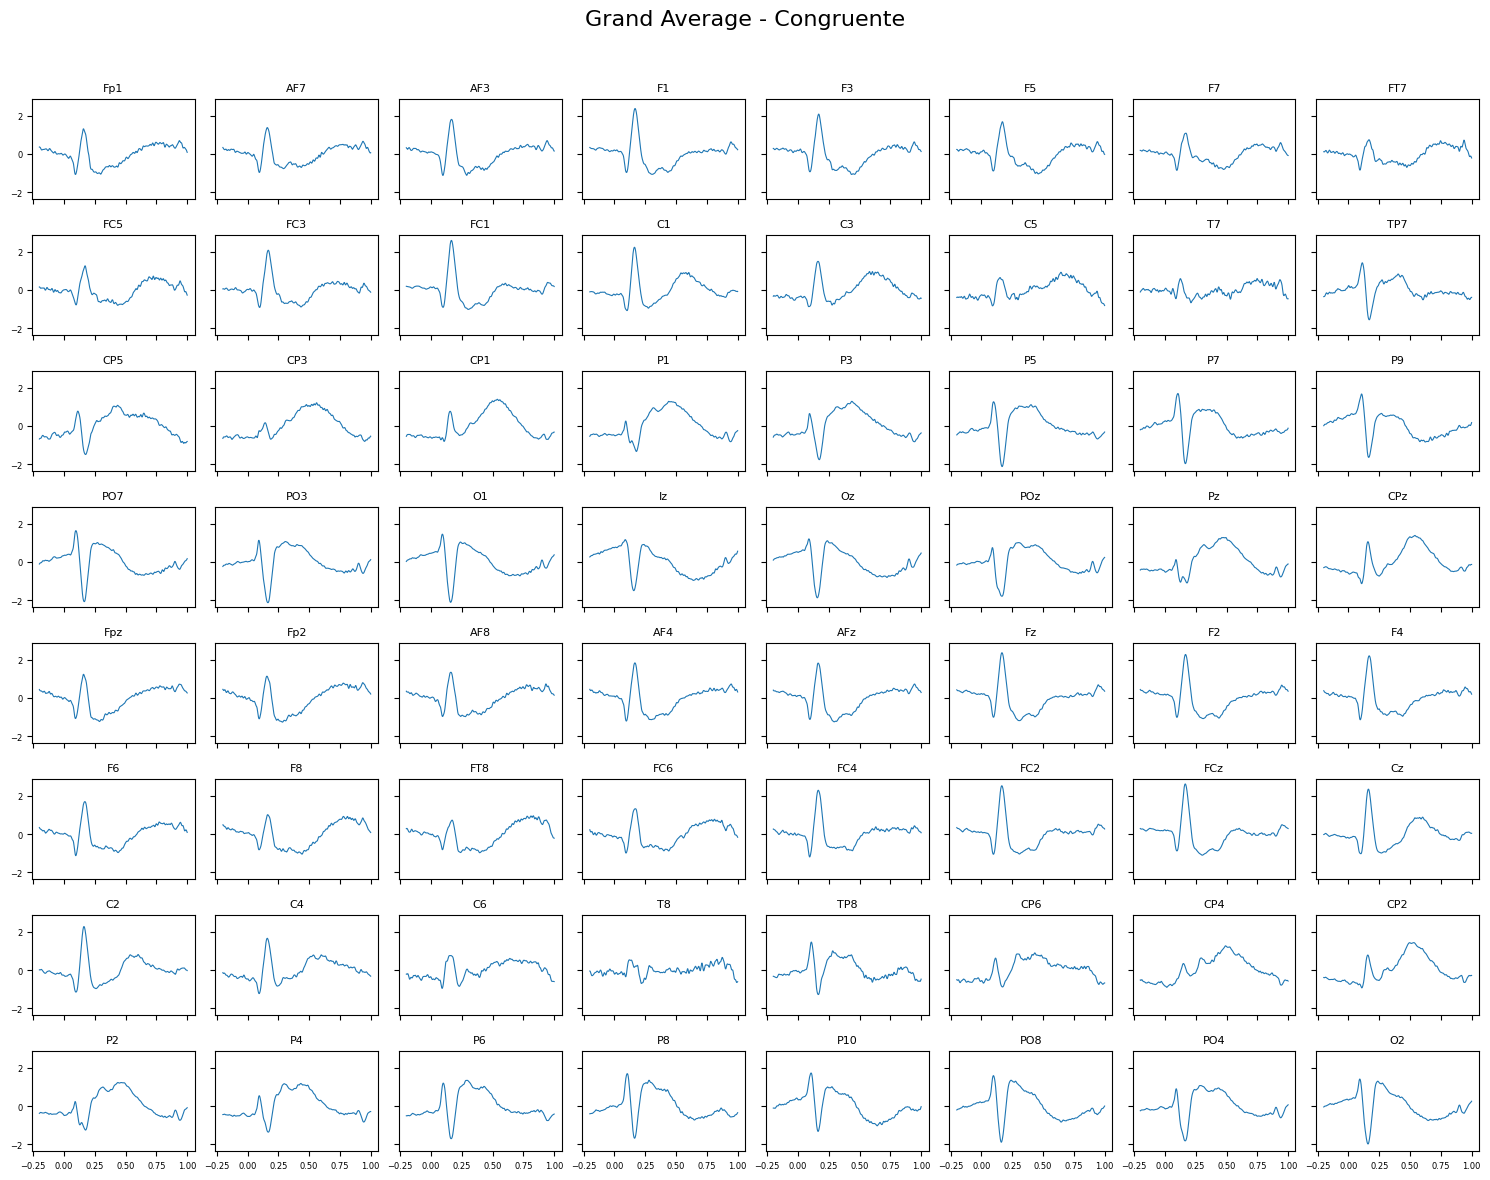

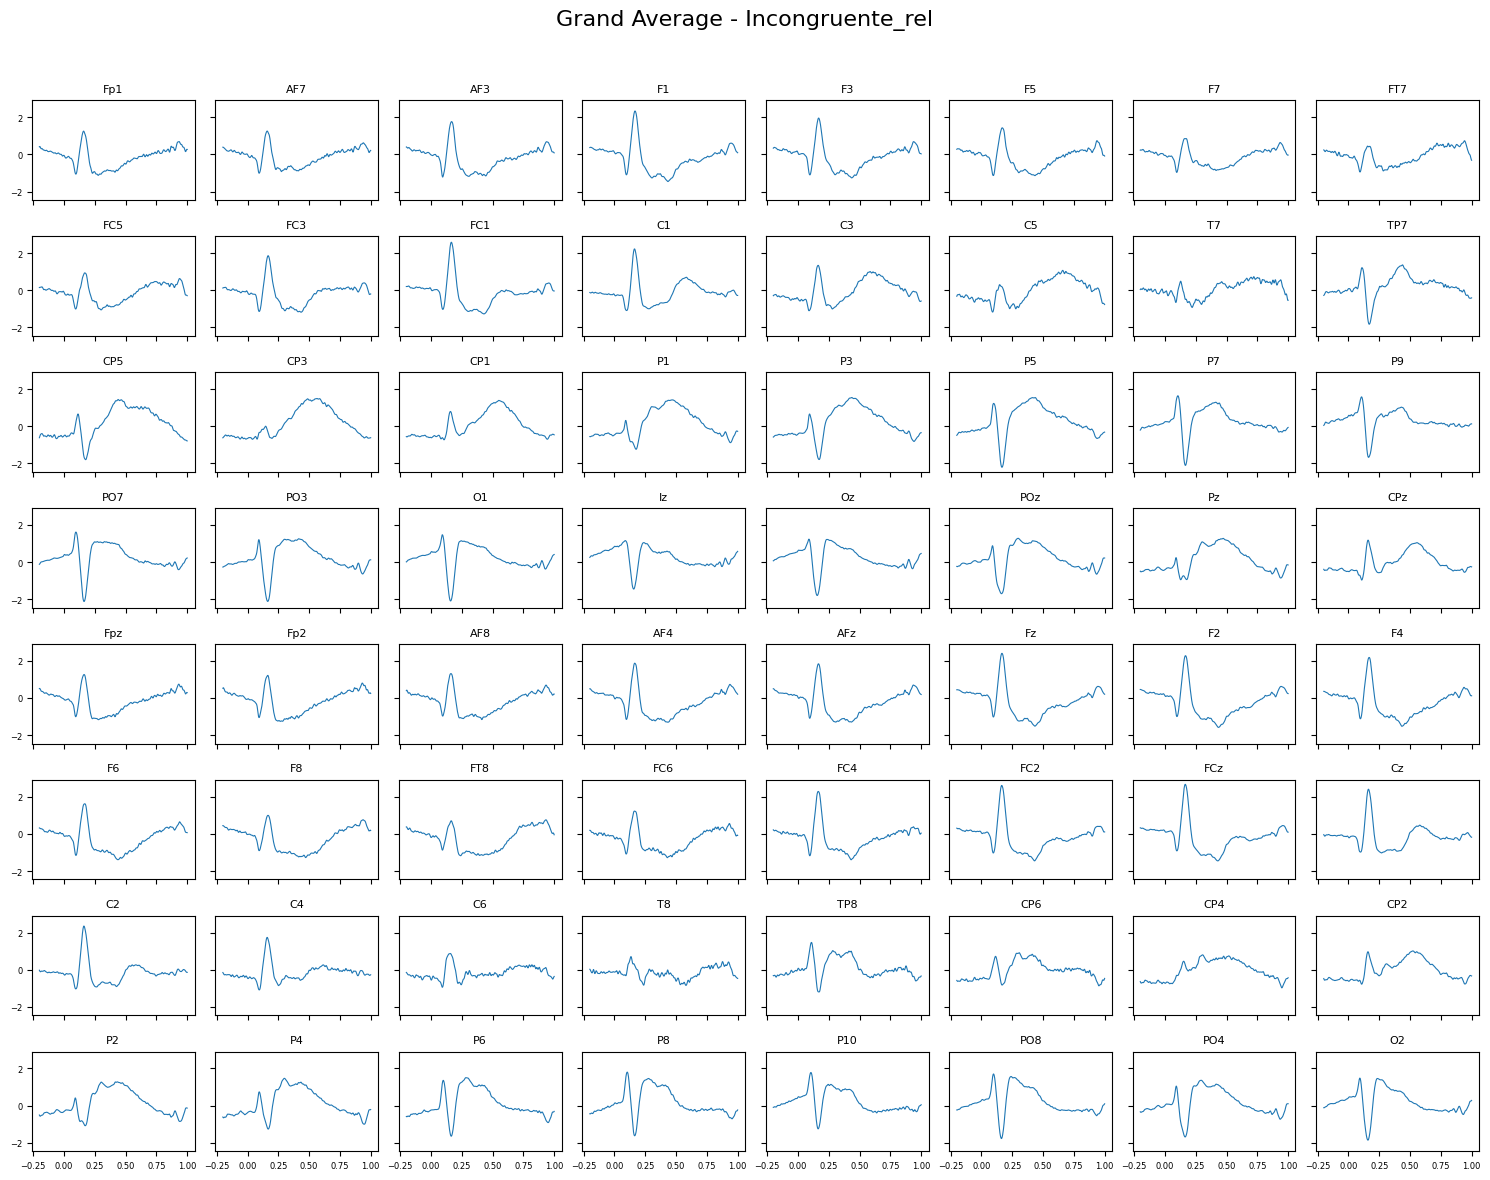

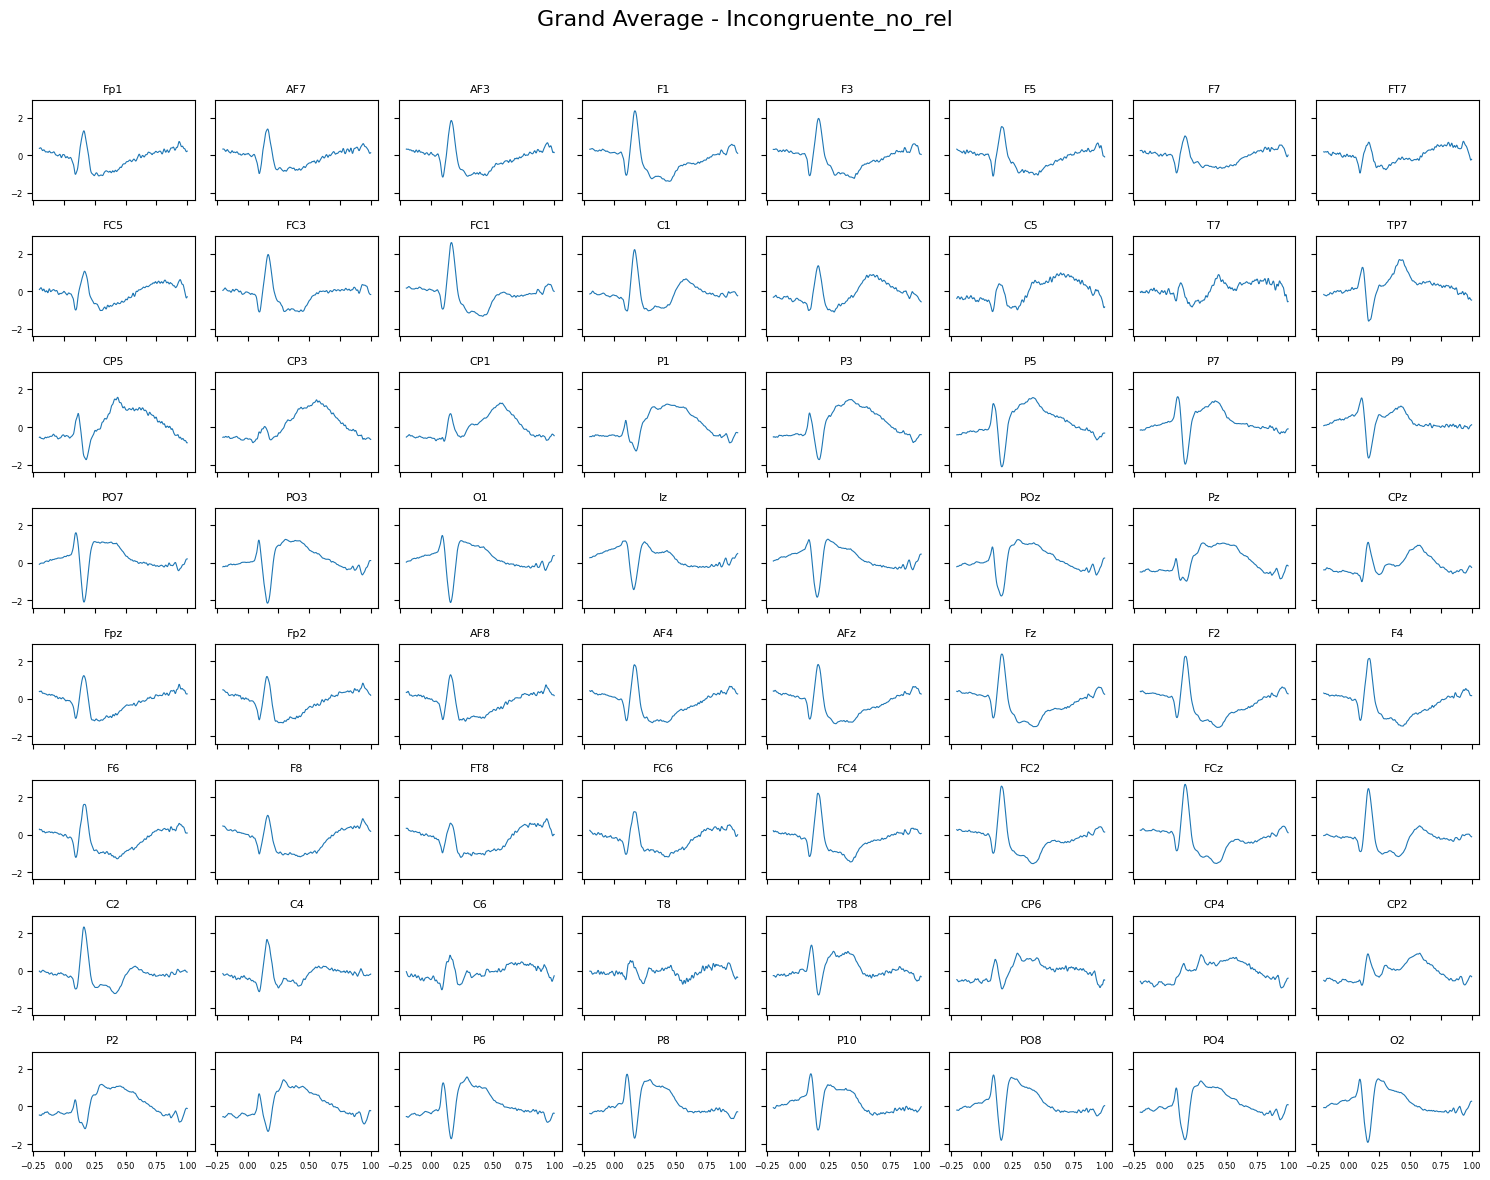

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def graficar_grand_average(grand_average, pre_estimulo_ms=200, frecuencia_muestreo=1024):
    """
    Genera 3 figuras, cada una con los 64 canales del Grand Average por condición,
    considerando un pre-estímulo de 200 ms.
    
    Parámetros:
    - grand_average: Diccionario con los promedios por condición.
    - pre_estimulo_ms: Tiempo antes del estímulo en milisegundos (por defecto 200 ms).
    - frecuencia_muestreo: Frecuencia de muestreo en Hz (por defecto 1024 Hz).
    """
    
    # Convertir el pre-estímulo de ms a segundos
    pre_estimulo_s = pre_estimulo_ms / 1000
    
    for condicion, raw_data in grand_average.items():
        if raw_data is None:
            print(f"No hay datos para graficar en la condición {condicion}.")
            continue
        
        data = raw_data.get_data()  # (Canales x Tiempos)
        tiempos = raw_data.times  # Tiempos en segundos
        canales = raw_data.ch_names
        
        # Desplazar los tiempos para comenzar en el pre-estímulo de 200 ms
        tiempos_desplazados = tiempos - pre_estimulo_s
        
        # Configurar la figura
        fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(15, 12), sharex=True, sharey=True)
        fig.suptitle(f"Grand Average - {condicion.capitalize()}", fontsize=16)
        
        axes = axes.flatten()  # Para iterar sobre los subgráficos más fácilmente
        
        # Graficar cada canal
        for i in range(len(canales)):
            axes[i].plot(tiempos_desplazados, data[i], label=canales[i], linewidth=0.8)
            axes[i].set_title(canales[i], fontsize=8)
            axes[i].tick_params(axis='both', which='both', labelsize=6)
        
        # Ajustar diseño
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

# Graficar los Grand Averages con el pre-estímulo de 200 ms y frecuencia de muestreo 1024 Hz
graficar_grand_average(grand_average, pre_estimulo_ms=200, frecuencia_muestreo=1024)


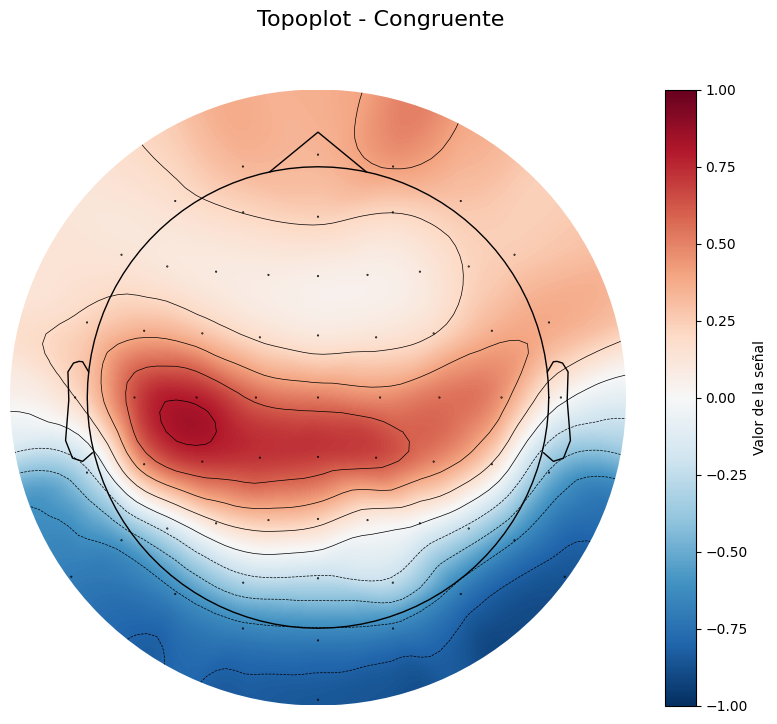

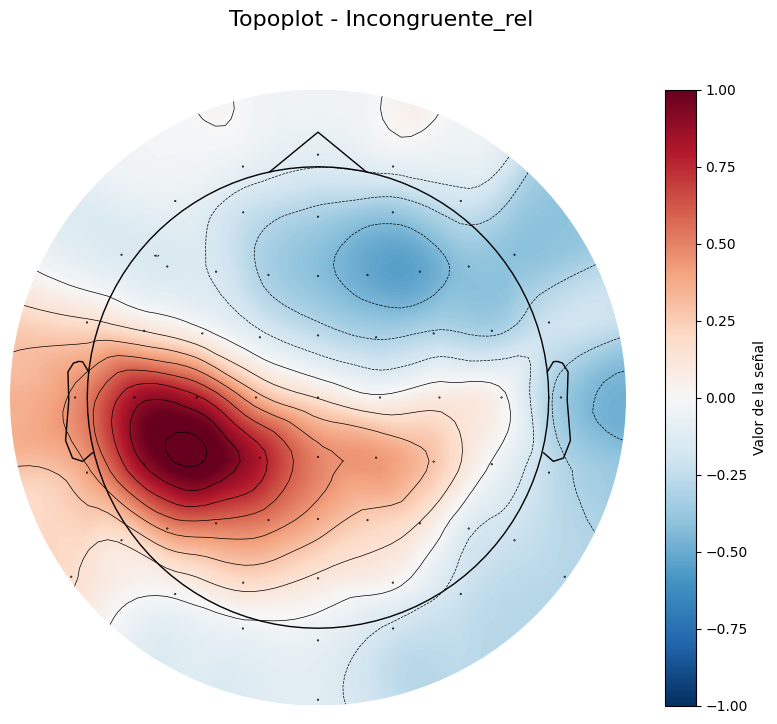

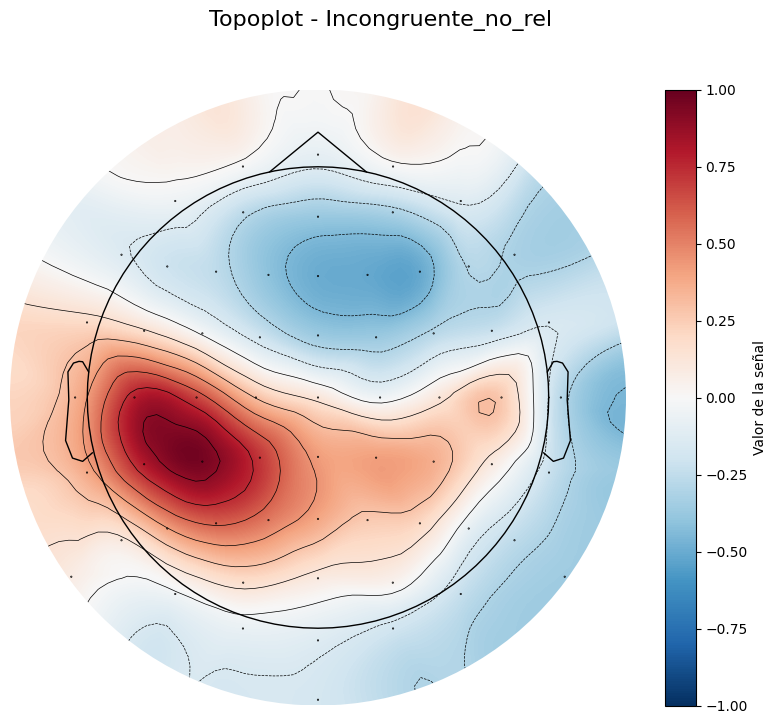

In [27]:
import numpy as np
import mne
import matplotlib.pyplot as plt

# Función para graficar el topoplot para cada condición en el rango de tiempo 550-750 ms
def graficar_topoplots(grand_average, tiempo_inicio_ms=750, tiempo_fin_ms=950, frecuencia_muestreo=1024):
    """
    Genera topoplot para cada condición en el rango de 550-750 ms.

    Parámetros:
    - grand_average: Diccionario con los promedios por condición.
    - tiempo_inicio_ms: Tiempo de inicio de la ventana (550 ms por defecto).
    - tiempo_fin_ms: Tiempo de fin de la ventana (750 ms por defecto).
    - frecuencia_muestreo: Frecuencia de muestreo en Hz (por defecto 1024 Hz).
    """
    
    # Convertir los tiempos de ms a segundos
    tiempo_inicio_s = tiempo_inicio_ms / 1000
    tiempo_fin_s = tiempo_fin_ms / 1000
    
    # Paso 1: Graficar los topoplots para cada condición usando la escala de colores entre -1 y 1
    for condicion, raw_data in grand_average.items():
        if raw_data is None:
            print(f"No hay datos para graficar en la condición {condicion}.")
            continue
        
        # Obtener los datos y tiempos
        data = raw_data.get_data()  # (Canales x Tiempos)
        tiempos = raw_data.times  # Tiempos en segundos
        
        # Seleccionar los índices de tiempo para la ventana de 550-750 ms
        idx_inicio = np.where(tiempos >= tiempo_inicio_s)[0][0]
        idx_fin = np.where(tiempos <= tiempo_fin_s)[0][-1]
        
        # Promediar los datos de la ventana seleccionada (550-750 ms)
        data_promediada = np.mean(data[:, idx_inicio:idx_fin], axis=1)
        
        # Crear un objeto Evoked para poder graficar
        info = raw_data.info  # Información de los datos EEG
        evoked = mne.EvokedArray(data_promediada[:, np.newaxis], info)
        
        # Usar el tamaño de la figura dentro de `plot_topomap`
        fig, ax = plt.subplots(figsize=(10, 8))  # Ajustar el tamaño de la figura
        
        # Graficar el topoplot con la escala de colores de -1 a 1
        im, _ = mne.viz.plot_topomap(evoked.data[:, 0], evoked.info, cmap="RdBu_r", contours=10, axes=ax, show=False)
        
        # Obtener los valores máximos y mínimos del topoplot para ajustar la escala manualmente
        valores = evoked.data[:, 0]
        vmin = -1
        vmax = 1
        
        # Establecer manualmente la escala de colores con la barra de color
        im.set_clim(vmin=vmin, vmax=vmax)
        
        # Agregar barra de color
        fig.colorbar(im, ax=ax, orientation='vertical', label='Valor de la señal')
        
        # Título y mostrar el gráfico
        fig.suptitle(f"Topoplot - {condicion.capitalize()}", fontsize=16)
        plt.show()

# Graficar los topoplots para cada condición en el rango de 550-750 ms
graficar_topoplots(grand_average, tiempo_inicio_ms=750, tiempo_fin_ms=950, frecuencia_muestreo=1024)


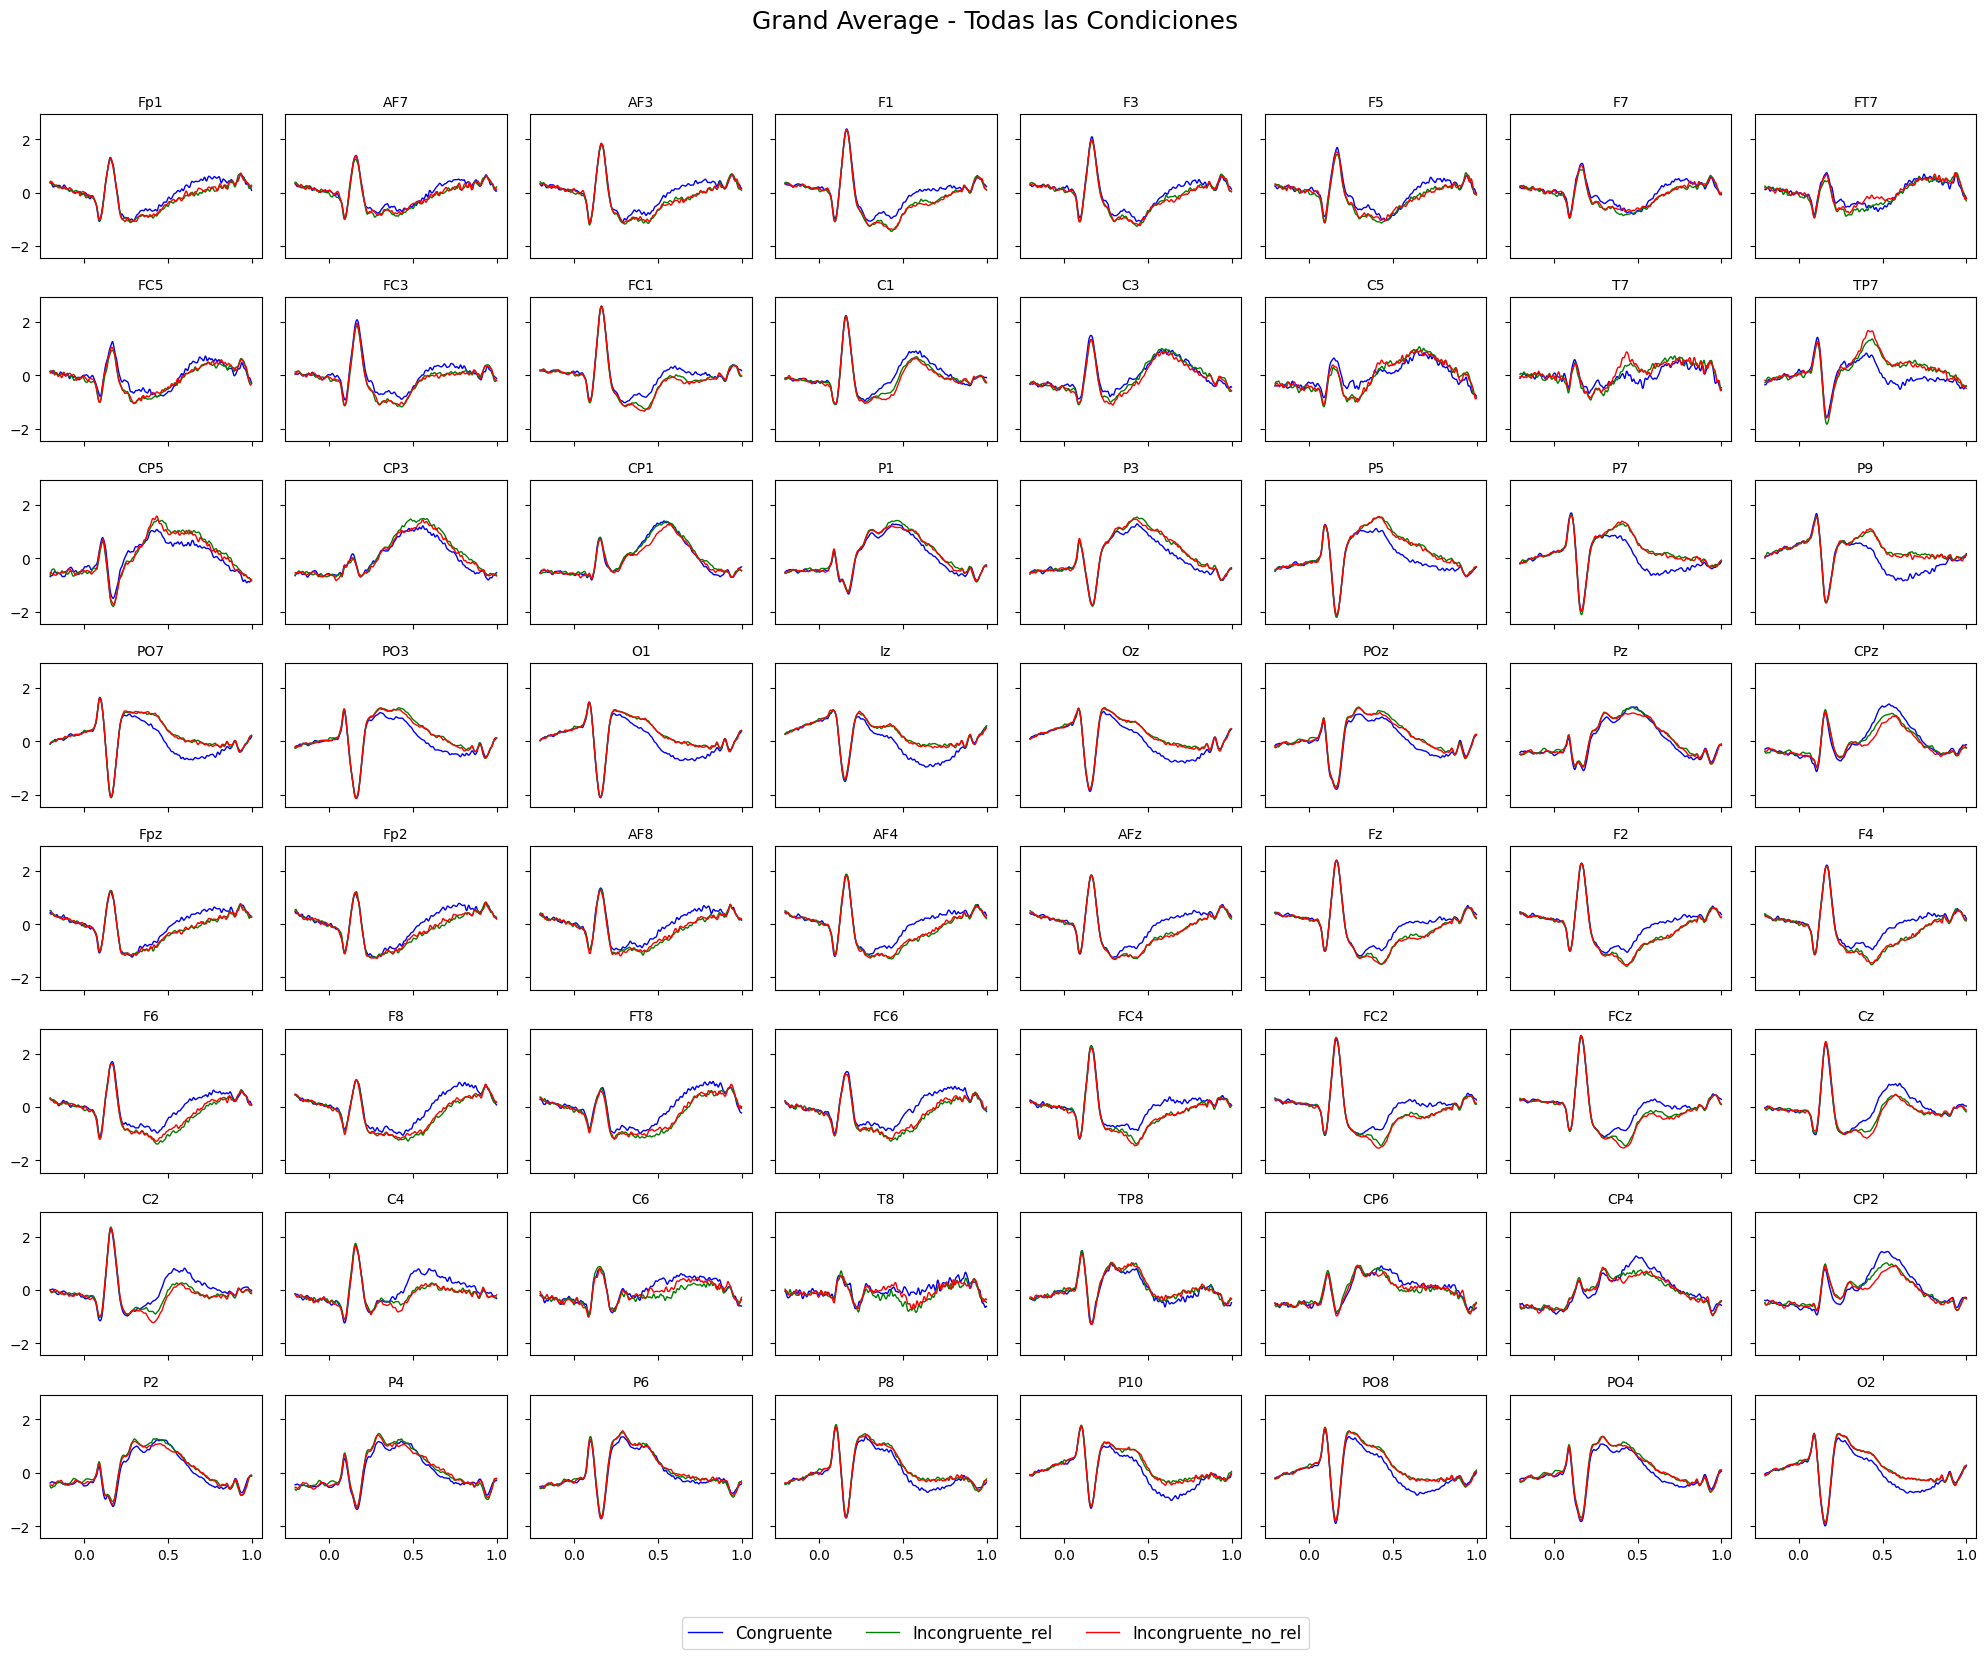

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def graficar_grand_average(grand_average, pre_estimulo_ms=200, frecuencia_muestreo=1024):
    """
    Genera un gráfico con los 64 canales del Grand Average por condición,
    para las tres condiciones (congruente, no congruente relacionado, no congruente no relacionado),
    considerando un pre-estímulo de 200 ms.
    
    Parámetros:
    - grand_average: Diccionario con los promedios por condición.
    - pre_estimulo_ms: Tiempo antes del estímulo en milisegundos (por defecto 200 ms).
    - frecuencia_muestreo: Frecuencia de muestreo en Hz (por defecto 1024 Hz).
    """
    
    # Convertir el pre-estímulo de ms a segundos
    pre_estimulo_s = pre_estimulo_ms / 1000
    
    # Definir colores para cada condición
    colores = {
        'congruente': 'blue',
        'incongruente_rel': 'green',
        'incongruente_no_rel': 'red'
    }
    
    # Configurar la figura con un tamaño mayor
    fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20, 16), sharex=True, sharey=True)
    fig.suptitle(f"Grand Average - Todas las Condiciones", fontsize=18)
    
    axes = axes.flatten()  # Para iterar sobre los subgráficos más fácilmente
    handles = []  # Para almacenar los objetos de la leyenda
    labels = []   # Para almacenar las etiquetas de la leyenda

    # Graficar las tres condiciones juntas
    for condicion, raw_data in grand_average.items():
        if raw_data is None:
            print(f"No hay datos para graficar en la condición {condicion}.")
            continue
        
        data = raw_data.get_data()  # (Canales x Tiempos)
        tiempos = raw_data.times  # Tiempos en segundos
        canales = raw_data.ch_names
        
        # Desplazar los tiempos para comenzar en el pre-estímulo de 200 ms
        tiempos_desplazados = tiempos - pre_estimulo_s
        
        # Graficar cada canal para la condición
        for i in range(len(canales)):
            line, = axes[i].plot(tiempos_desplazados, data[i], label=condicion.capitalize(), 
                                 color=colores.get(condicion, 'black'), linewidth=1)
            axes[i].set_title(canales[i], fontsize=10)
        
        # Agregar a la lista de la leyenda solo una vez por condición
        handles.append(line)
        labels.append(condicion.capitalize())
    
    # Ajustar diseño
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Agregar la leyenda fuera de la cuadrícula de gráficos
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=3, fontsize=12)
    
    plt.show()

# Graficar los Grand Averages con el pre-estímulo de 200 ms y frecuencia de muestreo 1024 Hz
graficar_grand_average(grand_average, pre_estimulo_ms=200, frecuencia_muestreo=1024)
